## 时间序列处理与检测
时间序列（Time Series, 缩写为TS）数据是最常见的一种地球物理测量数据表现形式。顾名思义，就是按照一定时间采样的测量数据。时间序列包括按照时间间隔的递增 (以分钟、小时、天、周为单位等) 来分类的数据使用。时间序列信号非常广泛，每天气温的变化、股票的涨跌、地震的波形记录和重力固体潮的变化等，通常至少包括时间列和测量值两列数据。   
针对地震会商业务系统中涉及的时间序列数据，对于原始时间序列中，可能因为仪器故障、干扰、传感器漂移等因素导致的时间序列产生断记、曲线突然变换和长周期的单向漂移等问题，需要对数据进行预处理，并在此基础上进行分析和基于模型预测。小G在本章根据地震会商业务需求，开发了连续时间序列分析模块。   
GEOIST的连续时间序列分析模块实现了连续时间序列（TS）的尖峰和突跳修补、ADF平稳性测试、去趋势、周期项分解、差分、移动平滑、指数平滑、距平分析、变采样、月平均与滤波、功率谱分析、ARIMA建模、异常检测等功能。 

### 连续时间序列分析模块功能
#### 数据导入
连续时间序列分析模块通过以下代码实现导入数据以及开始分析过程。其中， import模块在GEOIST的Snoopy目录下，带了orig_file和water_file两个示例数据，可直接打开查看。接着通过pandas的read_csv函数读入数据，返回的对象实例为data。

/home/pi/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


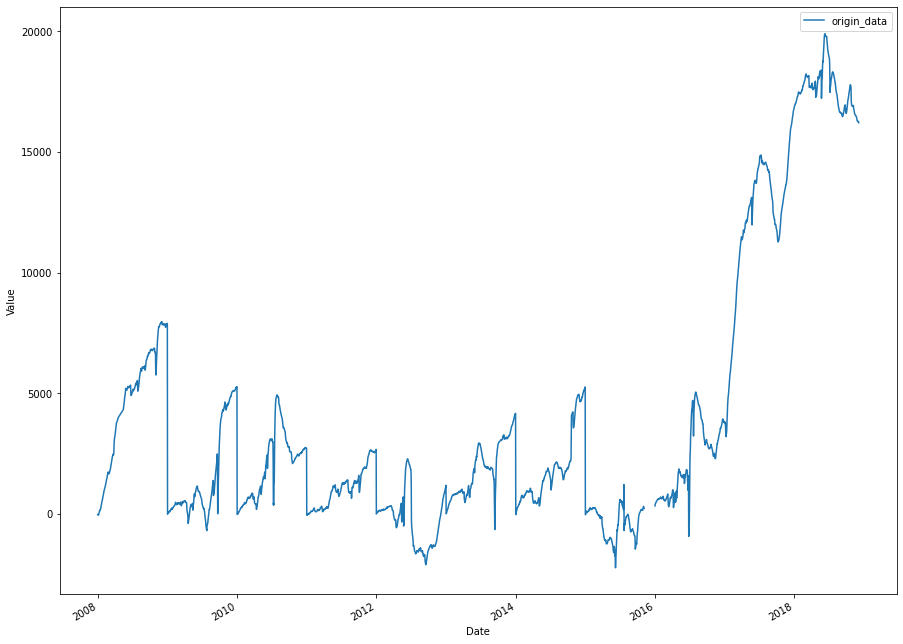

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geoist.snoopy.tsa as tsa
# parameters for loading data
data_path = Path(tsa.__file__).parent
orig_file = Path(data_path,"data",'50002_1_2312.txt')
water_file = Path(data_path,"data",'water_level_res.txt')
# parameters for processing data
na_values = None
# load data
data=pd.read_csv(Path(orig_file),parse_dates=[[0,1]],header=None,
delim_whitespace=True,index_col=[0],na_values=na_values)
data.index.name = 'time'
data.columns = ['origin_data']
ax=data.plot(figsize=(15,12),y=data.columns[0])
ax.set_xlabel('Date')
ax.set_ylabel('Value')

#### 尖峰、突跳修补
基于GEOIST软件包，通过导入的tsa模块里面的despike_v2函数，在上一部分导入数据data的基础上，对原始数据进行处理，引入thresh_hold参数判断原始数据中是否存在突跳。

Text(0.0, 1.0, 'The preliminary result by threshold=200.0')

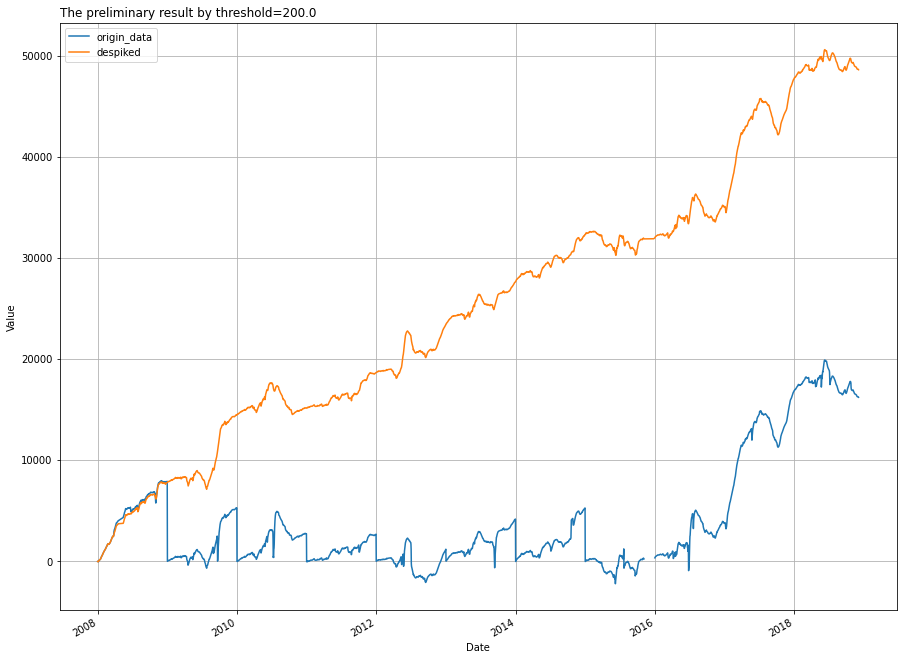

In [2]:
thresh_hold = 200.0
data['despiked'],data['flag'] = tsa.despike_v2(data['origin_data'].interpolate(),
th=thresh_hold)
ax=data.plot(figsize=(15,12),y=data.columns[:-1])
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.grid()
plt.legend()
plt.title("The preliminary result by threshold={}".format(thresh_hold),loc='left')

上图是处理结果，橙色曲线是经过尖峰、突跳修补预处理过后的时间序列信号。和蓝色的原始数据相比，橙色曲线更能反映数据的正常变化。

#### ADF平稳性测试
要对一个时间序列进行分析、建模和预测，首先要了解序列的性质。ADF（Augmented Dickey-Fuller） 平稳性检验可以用来检验一个序列是否平稳。
连续时间序列信号经过尖峰、突跳修补等预处理后，得到的信号就可进行ADF平稳性测试。ADF测试在 tsa模块中的功能函数为adfuller。其中新定义的window_size参数，指代每次测量的连续时间序列序列窗长，给定不同的值，结果可能会有一定的变化。

Augmented Dickey-Fuller test for despiked data:
  adf: -0.8225755579593916
  p-value: 0.8124005630822033
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


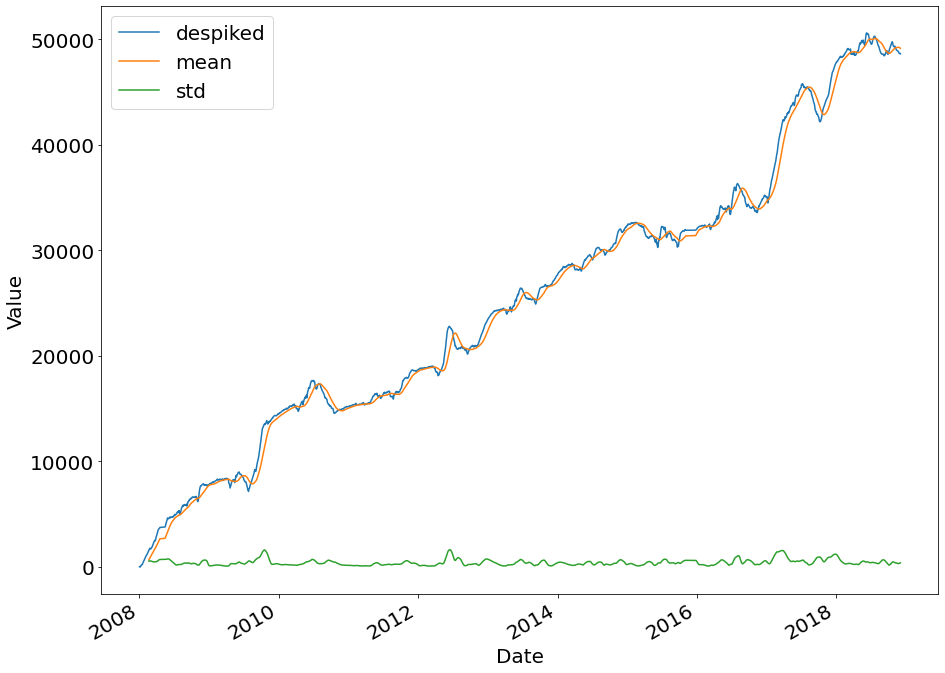

In [6]:
res = tsa.adfuller(data['despiked'].values) 
tsa.print_adf(res,'despiked data') 
window_size = 50 
data['mean'] = data['despiked'].rolling(window=window_size).mean()
data['std'] = data['despiked'].rolling(window=window_size).std() 
ax=data.plot(figsize=(15,12),y=['despiked','mean','std'],fontsize=20)
ax.set_xlabel('Date',fontsize=20)
ax.set_ylabel('Value',fontsize=20)
plt.legend(fontsize=20)

ADF平稳性测试的代码和结果如下所示。

In [7]:
res = tsa.adfuller(data['despiked'].values) 
tsa.print_adf(res,'despiked data')

Augmented Dickey-Fuller test for despiked data:
  adf: -0.8225755579593916
  p-value: 0.8124005630822033
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


#### 去趋势
以上连续时间序列信号ADF平稳性测试结果中的p值较大，主要是与数据中的趋势项有关，那么，如果去掉趋势呢？tsa中的detrend函数可以有效去除趋势项。

<AxesSubplot:xlabel='time'>

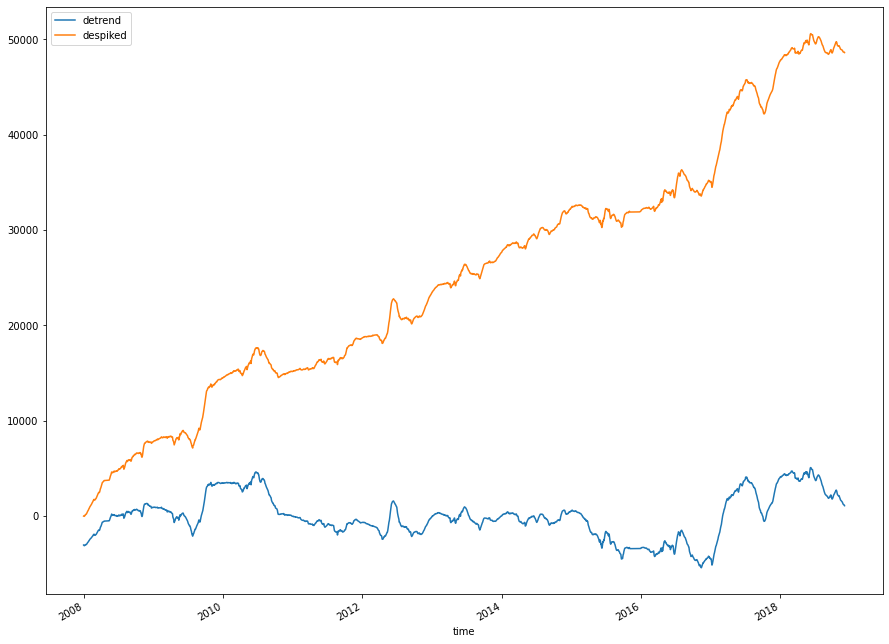

In [8]:
data['detrend'] = tsa.detrend(data['despiked']) 
data.plot(figsize=(15,12),y=['detrend','despiked'])

在去趋势结果基础上，再进行一次ADF测试。

Augmented Dickey-Fuller test for detrended data:
  adf: -2.8626974817975093
  p-value: 0.04986090928335365
  norder: 11
  number of points: 3903
  critical values:
    1% : -3.4320265580345004
    5% : -2.8622808115385583
    10% : -2.567164342737072


<AxesSubplot:xlabel='time'>

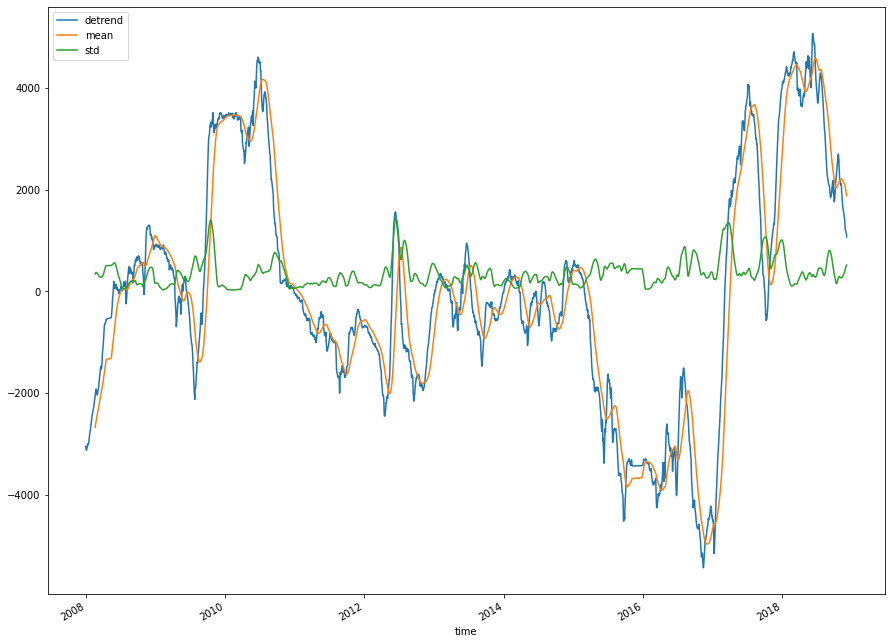

In [9]:
res = tsa.adfuller(data['detrend'].values) 
tsa.print_adf(res,'detrended data') 
data['mean'] = data['detrend'].rolling(window=window_size).mean()
data['std'] = data['detrend'].rolling(window=window_size).std() 
data.plot(figsize=(15,12),y=['detrend','mean','std'])

上述结果表明p值大大减小，这说明信号相对更加平稳。
#### 周期项分解
除了直接去除线性趋势的方法，连续时间序列分析模块还可以采用以鲁棒局部加权回归作为平滑方法的时间序列分解STL (Seasonal and Trend decomposition using Loess)方法，即把时间序列分解为趋势项(trend component)、季节项(seasonal component)和余项(remainder component)的过滤过程。同样，GEOIST软件包中的snoopy模块包含该函数，在tsa模块的seasonal_decompose函数中，用法如下：

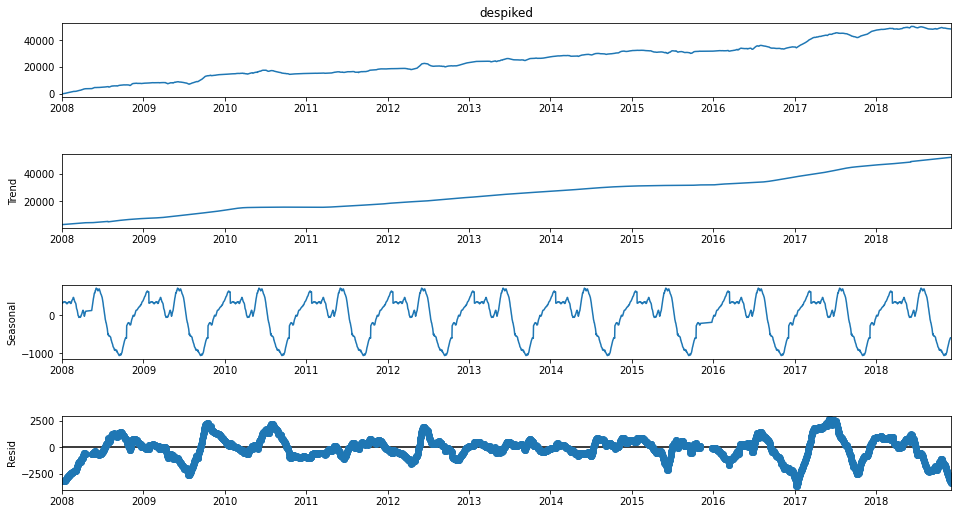

In [11]:
period = 365 
na_values_output = np.nan 
decomposition = tsa.seasonal_decompose(data['despiked'],period=period,extrapolate_trend='freq') 
fig=decomposition.plot() 
fig.set_size_inches(15,8) 
data['trend'] = decomposition.trend.fillna(na_values_output) 
data['seasonal'] = decomposition.seasonal.fillna(na_values_output) 
data['residual'] = decomposition.resid.fillna(na_values_output)

做完STL分解后，我们又进行了一遍ADF（Augmented Dickey-Fuller）测试。

Augmented Dickey-Fuller test for residual data:
  adf: -5.196623657704766
  p-value: 8.932706805881288e-06
  norder: 13
  number of points: 3901
  critical values:
    1% : -3.432027418154056
    5% : -2.8622811914877873
    10% : -2.567164545006864


<AxesSubplot:xlabel='time'>

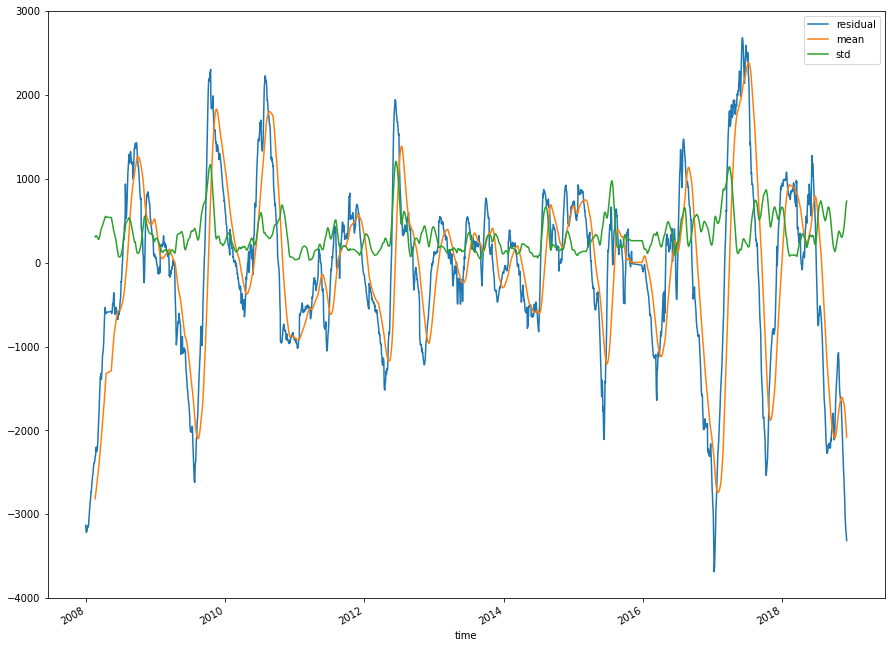

In [12]:
# test stationary on residual 
res = tsa.adfuller(data['residual'].dropna().values) 
tsa.print_adf(res,'residual data') 
window_size=50
data['mean'] = data['residual'].rolling(window=window_size).mean() 
data['std'] = data['residual'].rolling(window=window_size).std() 
data.plot(figsize=(15,12),y=['residual','mean','std'])

残差（residual）、均值（mean）和标准差的变化如上图所示。   
ADF测试量化结果如下，p值又小了不少，这说明方法是有效的。
#### 差分和平滑
除了上文的预处理，稳定性检测和去趋势功能，连续时间序列信号模块还包括常用的差分、平滑等常规数据处理方法。差分和平滑处理可以直接引用Pandas的dataframe数据类型中diff，rolling，ewm等接口。
##### 差分

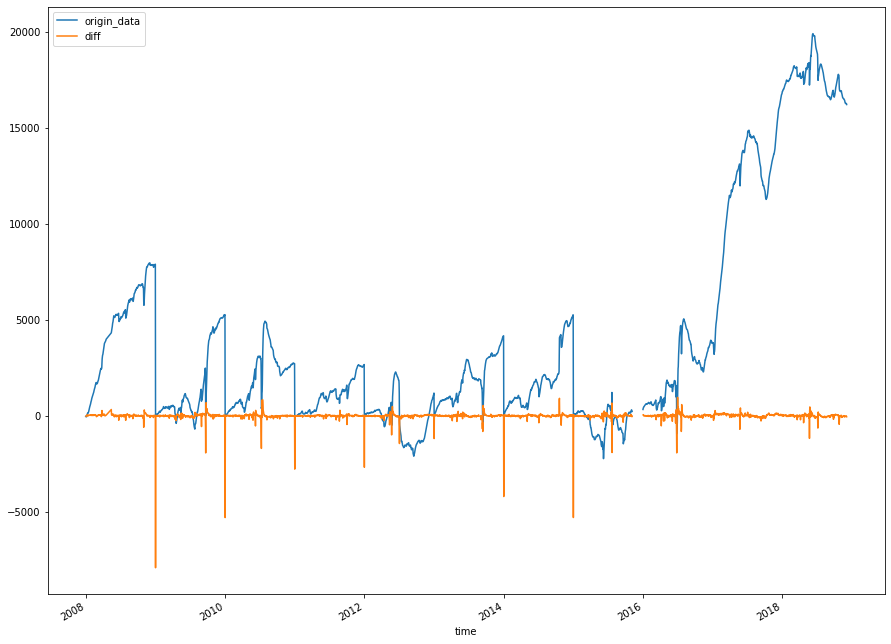

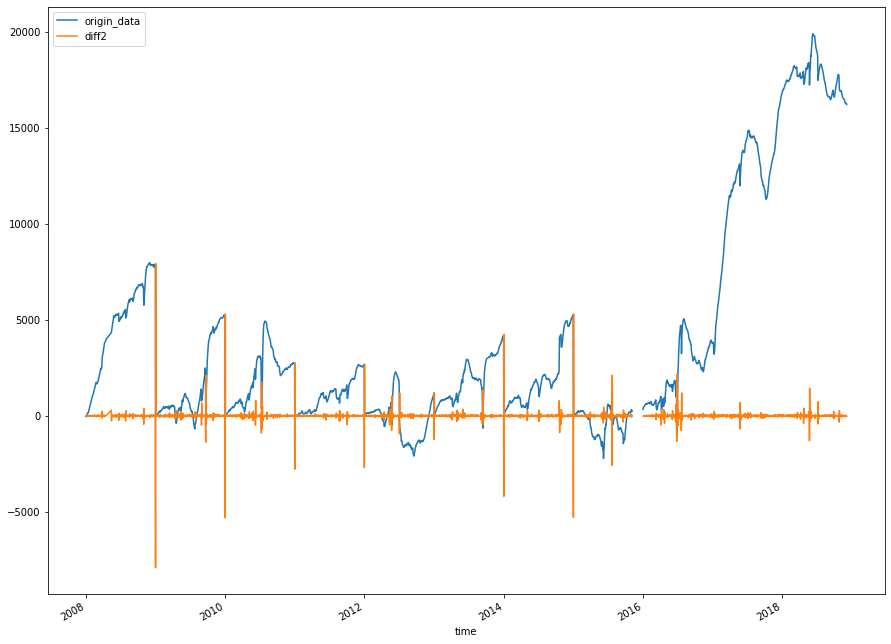

In [13]:
# first order difference 
data['diff'] = data['origin_data'].diff() 
ax = data.plot(figsize=(15,12),y=['origin_data','diff']) 
# second order difference 
data['diff2'] = data['diff'].diff() 
ax = data.plot(figsize=(15,12),y=['origin_data','diff2'])

##### 滑动平均
滑动平均是连续时间序列信号分析最常用的一种低通滤波方法，在连续时间序列分析模块中通过rolling函数实现。方法如下：

<AxesSubplot:xlabel='time'>

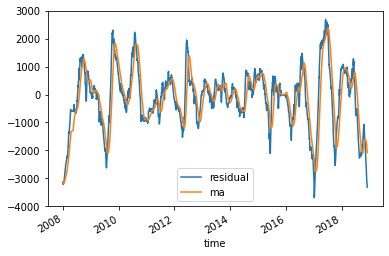

In [14]:
# moving average 
window_size = 50 
center = False 
data['ma'] = data['residual'].rolling(window=window_size,center=center,min_periods=1).mean() 
data.plot(y=['residual','ma'])

##### 指数平滑
连续时间序列分析模块中除了滑动平均外，还包括指数平滑法。该方法由布朗(Robert G..Brown)提出，他认为时间序列的态势具有稳定性或规则性，所以时间序列可被合理地顺势推延。方法认为最近的过去态势，在某种程度上会持续到最近的未来，所以将较大的权数放在最近的资料。该方法原理是任一期的指数平滑值都是本期实际观察值与前一期指数平滑值的加权平均。具体公式如下：
$$
S_t = \alpha y_{tt}+(1-\alpha)SS_{t-1}
$$
上式中，$S_t$为时间$t$的平滑值，$y_tt$为观测值，$a$为平滑常数。    
简单的全期平均法是对"时间数列"的过去数据一个不漏地全部加以同等利用；移动平均法则不考虑较远期的数据，并在"加权移动平均法"中给予近期资料更大的权重；而指数平滑法则兼容了全期平均和移动平均所长，不舍弃过去的数据，但是仅给予逐渐减弱的影响程度，即随着数据的远离，赋予逐渐收敛为零的权数。也就是说指数平滑法是在"移动平均法"基础上发展起来的一种“时间序列分析预测法”，它是通过计算指数平滑值，配合一定的时间序列预测模型对现象的未来进行“预测”。原理是任一期的指数平滑值都是本期实际观察值与前一期指数平滑值的加权平均。   
连续时间序列信号分析模块中指数平滑的实际用法如下：


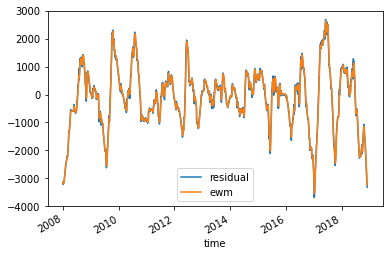

In [15]:
# exponential moving average
factor = 0.3 
data['ewm'] = data['residual'].ewm(alpha=factor).mean() 
data.plot(y=['residual','ewm'])

#### 距平分析
距平是某一系列数值中的某一个数值与平均值的差，分正距平和负距平。距平分析常用于分析具有显著周期性的信号，如：气象观测数据。距平值用来确定某个时段或时次的数据，相对于该数据的某个长期平均值。举个例子：一个地区某天的平均气温是14度，该地区该天平均气温的30年平均值是12度，那么该地区该天的平均气温距平就是2度。2度的距平表明今天的平均气温相对于该地区该天平均气温的30年平均值偏高2度。但是人体所能感觉的真实气温是14度。    
连续时间序列分析模块中的距平分析方法，通过tsa模块的departure函数实现，具体用法如下：

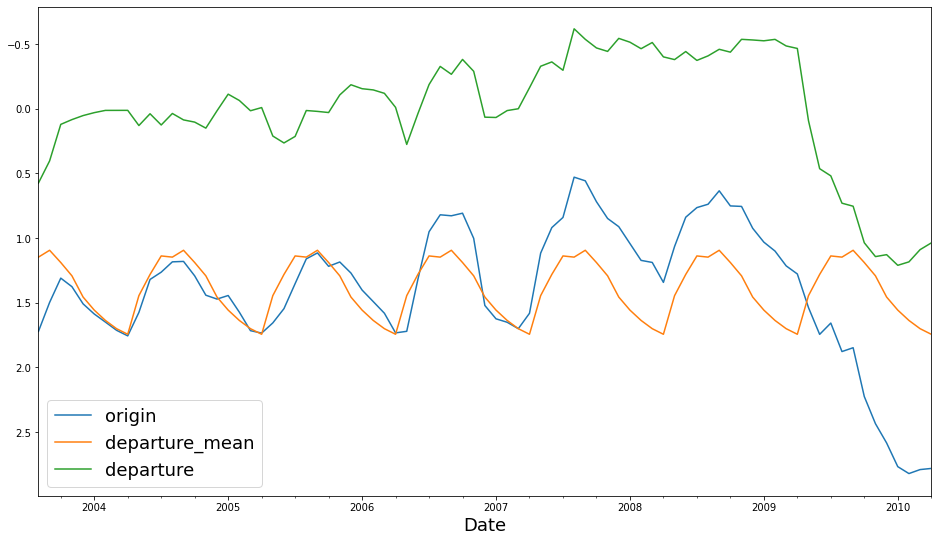

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geoist.snoopy.tsa as tsa
data_path = Path(tsa.__file__).parent
water_file = Path(data_path,"data",'water_level_res.txt')

dateparser = lambda x: pd.to_datetime(x,format='%Y%m') 
water = pd.read_csv(water_file,header=None,parse_dates=True, 
index_col=0,delim_whitespace=True,date_parser=dateparser) 
water[water == 99999] = np.nan 
water = water.interpolate() 
water.columns = ['origin','mean','departure'] 
water_origin = pd.DataFrame(water[water.columns[0]]).copy()
# call departure, and plot. 
water_origin,_ = tsa.despike_v2(water_origin,th=200) 
wate_departure = tsa.departure(water_origin) 
ax = wate_departure.plot(figsize=(16,9)) 
ax.invert_yaxis()
ax.set_xlabel('Date',fontsize=18)
plt.legend(fontsize=18)
plt.savefig("20-9.pdf")

距平分析结果如上图所示，图中绿色的departure曲线就是距平值，明显可见在2009-2010年的变化最大。

#### 变采样、月平均与滤波
连续时间序列分析模块中的dataframe支持支持变采样和月平均等重采样功能，通过resample函数实现。函数的用法如下：

In [17]:
# upsample 
water_daily = water_origin.resample('D').asfreq().interpolate() 
water_daily.head(10) 
# downsample 
water_monthly = water_daily.resample('MS').asfreq().interpolate() 
water_monthly.head(10) 
# monthly mean 
water_monthly = water_daily.resample('MS').mean().interpolate() 
water_monthly.head(10) 

,origin,departure_mean,departure
0,,,
2003-08-01,1.612913,1.121462,0.491451
2003-09-01,1.406578,1.139907,0.266672
2003-10-01,1.341535,1.238634,0.102902
2003-11-01,1.439835,1.371030,0.068805
2003-12-01,1.546387,1.504623,0.041765
2004-01-01,1.617042,1.595389,0.021653
2004-02-01,1.680003,1.667430,0.012574
2004-03-01,1.733706,1.721296,0.012410
2004-04-01,1.668272,1.599229,0.069043


前面的介绍，还都仅限于时间域的分析方法，没有涉及频率域的方法。tsa模块中的滤波函数，使用方法如下：

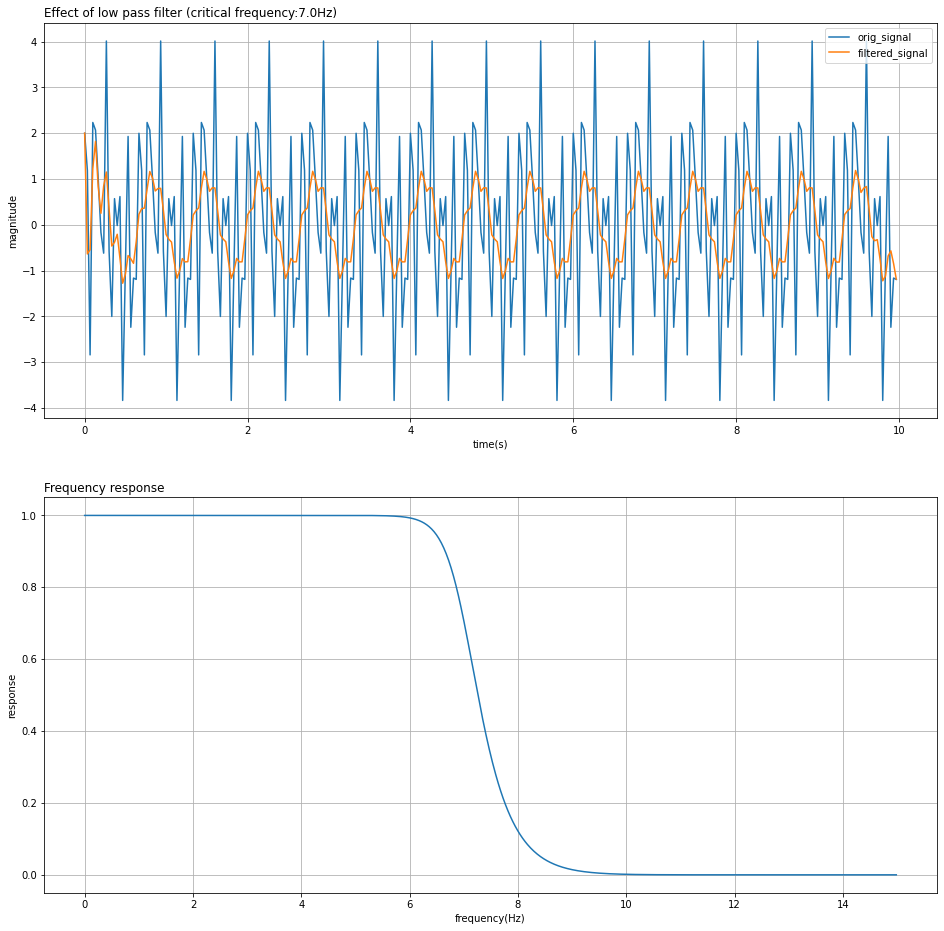

In [18]:
# filter
# generate dataset 
sample_rate = 30.0 
n = np.arange(300) 
orig_data = np.sin(0.1*np.pi*n)+2.0*np.cos(0.5*np.pi*n)+1.5*np.sin(0.8*np.pi*n) 
# generate filter 
order = 10 
nyq = 0.5*sample_rate 
lower_cut_rate = 7.0 / nyq 
upper_cut_rate = 10.0 / nyq 
sos = tsa.butter(10,lower_cut_rate,btype='low',output='sos') 
# apply filter to data 
filtered_data = tsa.sosfiltfilt(sos,orig_data) 
# plot data 
fig = plt.figure(figsize=(16,16)) 
ax = plt.subplot(211) 
ax.plot(n/sample_rate,orig_data,label='orig_signal') 
ax.plot(n/sample_rate,filtered_data,label='filtered_signal') 
ax.set_xlabel('time(s)') 
ax.set_ylabel('magnitude') 
ax.legend() 
plt.title('Effect of low pass filter (critical frequency:{}Hz)'.format(lower_cut_rate*nyq),loc='left') 
plt.grid() 
ax = plt.subplot(212) 
w,h = tsa.sosfreqz(sos,worN=1000) 
ax.plot(0.5*sample_rate*w/np.pi,np.abs(h)) 
ax.set_xlabel('frequency(Hz)') 
ax.set_ylabel('response') 
plt.title('Frequency response',loc='left') 
plt.grid()

上面的代码实现功能包括：首先模拟产生连续时间序列信号，并对其进行滤波，最后进行频谱分析，得到频谱结果，效果如上图所示。

#### 功率谱分析
连续时间序列信号的频率分析方法，离不开功率谱密度（PSD）。因为物理学中，信号通常是波的形式表示，例如电磁波、随机振动或者声波。当波的功率频谱密度乘以一个适当的系数后将得到每单位频率波携带的功率，这被称为信号的功率谱密度（power spectral density, PSD）。    
GEOIST连续时间序列分析模块的功率谱密度通过welch、lombscargle和periodogram三个函数实现。具体方法如下：

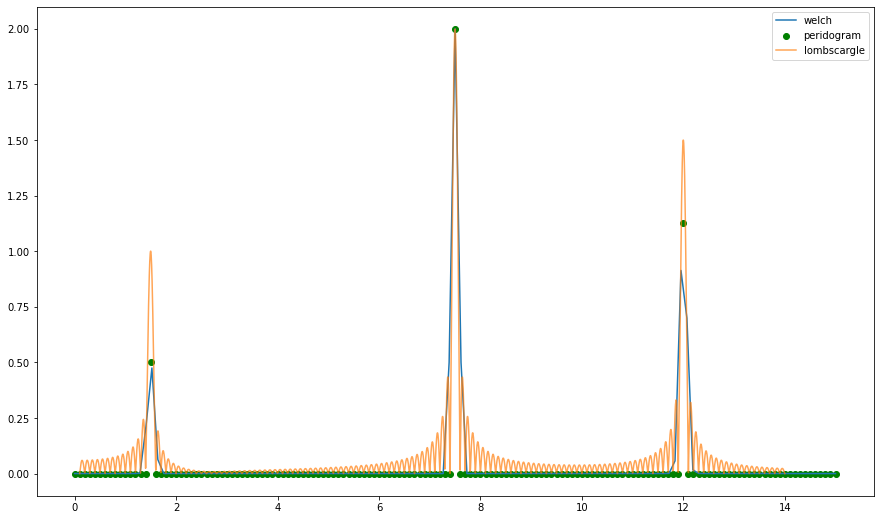

In [19]:
# psd 
import numpy as np
import matplotlib.pyplot as plt
import geoist.snoopy.tsa as tsa
sample_rate = 30.0 
n = np.arange(300) 
orig_data = np.sin(0.1*np.pi*n)+2.0*np.cos(0.5*np.pi*n)+1.5*np.sin(0.8*np.pi*n) 

f_w,pxx_w = tsa.welch(orig_data,sample_rate,nperseg=256,scaling='spectrum') 
f_p,pxx_p = tsa.periodogram(orig_data,sample_rate,scaling='spectrum') 
f_l = np.linspace(0.1,14,3000)*np.pi*2.0 
pxx_l = tsa.lombscargle(n/sample_rate,orig_data,f_l) 
# plot result 
fig = plt.figure(figsize=(15,9)) 
ax = fig.add_subplot(111)
ax.plot(f_w,pxx_w,label='welch') 
ax.scatter(f_p,pxx_p,label='peridogram',c='g') 
ax.plot(0.5*f_l/np.pi,np.sqrt(pxx_l*4.0/len(orig_data)),alpha=0.7,label='lombscargle') 
ax.legend()

#### ARIMA建模
连续时间序列信号的预处理包括两个方面的检验，平稳性检验和白噪声检验。能够适用ARMA模型进行分析预测的时间序列必须满足的条件是平稳非白噪声序列。   
连续时间序列模块中ARIMA模型的实现代码如下：


C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\DELL\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  w

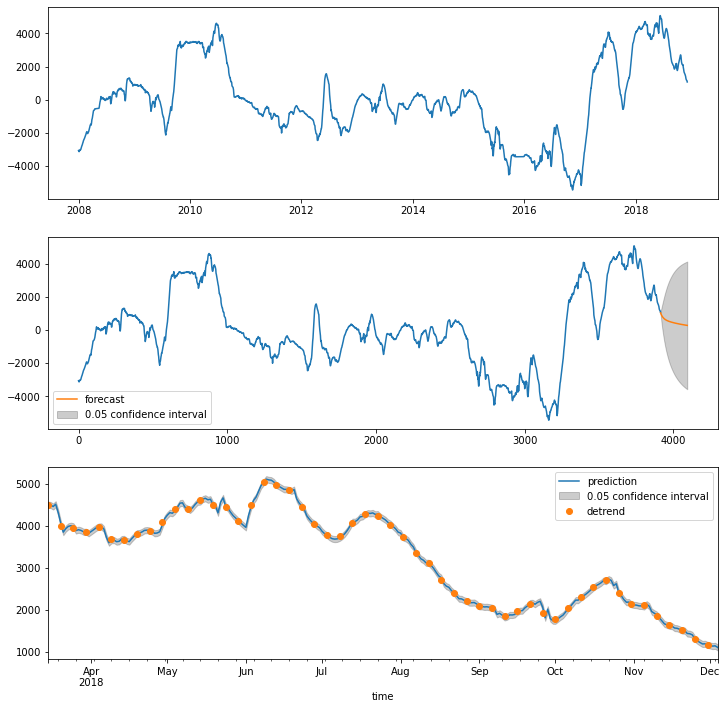

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geoist.snoopy.tsa as tsa
# parameters for loading data
data_path = Path(tsa.__file__).parent
orig_file = Path(data_path,"data",'50002_1_2312.txt')
# parameters for processing data
na_values = None
# load data
data=pd.read_csv(Path(orig_file),parse_dates=[[0,1]],header=None,
delim_whitespace=True,index_col=[0],na_values=na_values)
data.index.name = 'time'
data.columns = ['origin_data']
thresh_hold = 200.0
data['despiked'],data['flag'] = tsa.despike_v2(data['origin_data'].interpolate(),
th=thresh_hold)
data['detrend'] = tsa.detrend(data['despiked'])

# ARIMA 
p = 5 
d = 0 
q = 1 
P, D, Q , s= 0, 0, 0, 0 
model = tsa.SARIMAX(data['detrend'].dropna(), 
order=(p,d,q), 
seasonal_order=(P,D,Q,s), 
enforce_stationarity=False) 
rests = model.fit() 
pred = rests.get_forecast(180) 
pci = pred.conf_int() 
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1,figsize=(12,12)) 
ax0.plot(data['detrend'].dropna()) 
ax1.plot(data['detrend'].dropna().values) 
pred.predicted_mean.plot(ax=ax1,label='forecast') 
ax1.fill_between(pci.index,pci.iloc[:,0],pci.iloc[:,1],color='k',
alpha=0.2,label='0.05 confidence interval') 
ax1.legend() 
start_day=365*10 
pred = rests.get_prediction(start_day) 
pci = pred.conf_int() 
pred.predicted_mean.plot(ax=ax2,label='prediction') 
ax2.fill_between(pci.index,pci.iloc[:,0],pci.iloc[:,1],color='k',alpha=0.2, 
label='0.05 confidence interval') 
data['detrend'].dropna().iloc[start_day:].asfreq('5d').plot(style='o',ax=ax2) 
ax2.legend()

### 连续时间序列异常检测
#### 异常检测
所谓异常检测就是发现与大部分对象不同的对象，其实就是发现离群点（Outliers）。异常检测有时也称偏差检测。异常对象是相对罕见的。在实际应用中，异常检测技术有很多应用，例如：  
##### 欺诈检测：主要通过检测异常行为来检测是否为盗刷他人信用卡；
##### 入侵检测：检测入侵计算机系统的行为；
##### 医疗领域：检测人的健康是否异常。

#### 异常检测算法分类
从学术角度，异常监测算法可以分为以下四大类：
##### 基于密度的方法（Density-Based Approaches）：
RKDE: Robust Kernel Density Estimation (Kim & Scott, 2008)；
EGGM: Ensemble Gaussian Mixture Model。
##### 基于分位数的方法（Quantile-Based Methods）：
OCSVM: One-class SVM (Schoelkopf, et al., 1999)；
SVDD: Support Vector Data Description (Tax&Duin, 2004)。
##### 基于邻近的方法（Neighbor-Based Methods）：
LOF: Local Outlier Factor (Breunig, et al., 2000)；
ABOD: kNN Angle-Based Outlier Detector (Kriegel, et al., 2008)。
##### 基于投影的方法（Projection-Based Methods）：
IFOR: Isolation Forest (Liu, et al., 2008)；
LODA: Lightweight Online Detector of Anomalies (Pevny, 2016)。
#### Snoopy模块的异常检测算法
GEOIST软件包中的Snoopy模块提供了异常检测算法和异常检测功能，来源于Linkedin开源的Luminol异常检测算法。Luminol是一个轻量级的用于时间序列数据分析的Python异常检测算法库。目前，Snoopy模块支持的两个主要功能是异常检测和相关性分析，可用来调查异常的可能原因。对连续时间序列信号，可检测数据是否包含异常，并返回一个发生异常的时间窗口。当一个异常达到其严重程度的时间戳，以及一个表示与时间序列中的其他异常相比严重程度的评分。对于给定的两个时间序列，可以帮助找出它们的相关系数。   
Snoopy同时也是完全可配置的，可扩展异常检测或相关的特定算法。此外，该库不依赖于时间序列值上的任何预定义阈值。相反，它为每个数据点分配一个异常分数，并使用该分数识别异常。通过使用该模块，可以为建立一个异常处理逻辑任务流程。例如，假设有一个网络延迟的峰值，首先进行异常检测，发现网络延迟时间序列中的峰值；其次获取峰值的异常周期，并在同一时间范围内与其他系统指标(GC、IO、CPU等)进行关联获得一个相关指标的排序列表。   
下面我们就简单看看异常检测的代码实现：


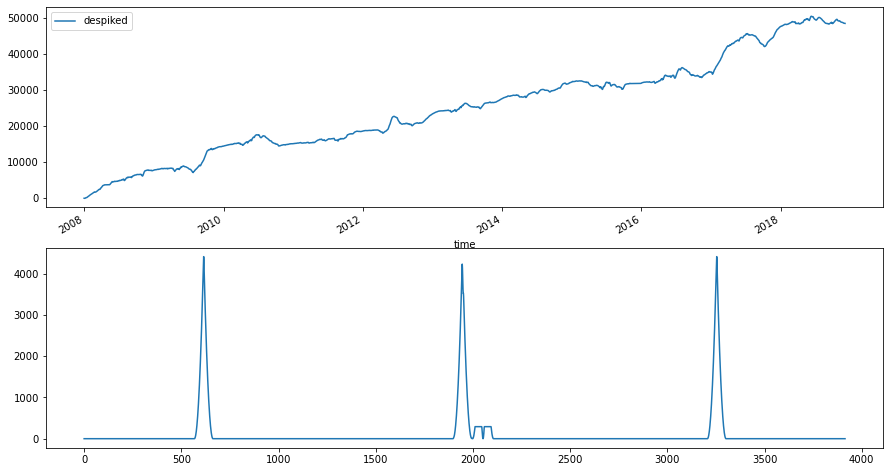

In [37]:
from geoist.snoopy.anomaly_detector import AnomalyDetector 
ts = dict(zip(range(len(data)),data['despiked'].values)) 
my_detector = AnomalyDetector(ts) 
score = my_detector.get_all_scores() 
fig = plt.figure(figsize=(15,9)) 
ax = fig.add_subplot(211) 
data.plot(ax=ax,y=['despiked']) 
ax = fig.add_subplot(212) 
ax.plot(score.timestamps,score.values)
ts = dict(zip(range(len(data)),data['despiked'].values))

#### 异常检测算法分析
连续时间序列分析模块中的异常检测算法的代码实现如下所示。其中，算法选择为“sign_test”，并设置了baseline曲线为tsb，算法参数设计参数详见algorithm_params。Snoopy的异常检测算法默认为“bitmap_detector”，此外，除了“sign_test”，还支持“diff_percent_threshold”，“exp_avg_detector”等。

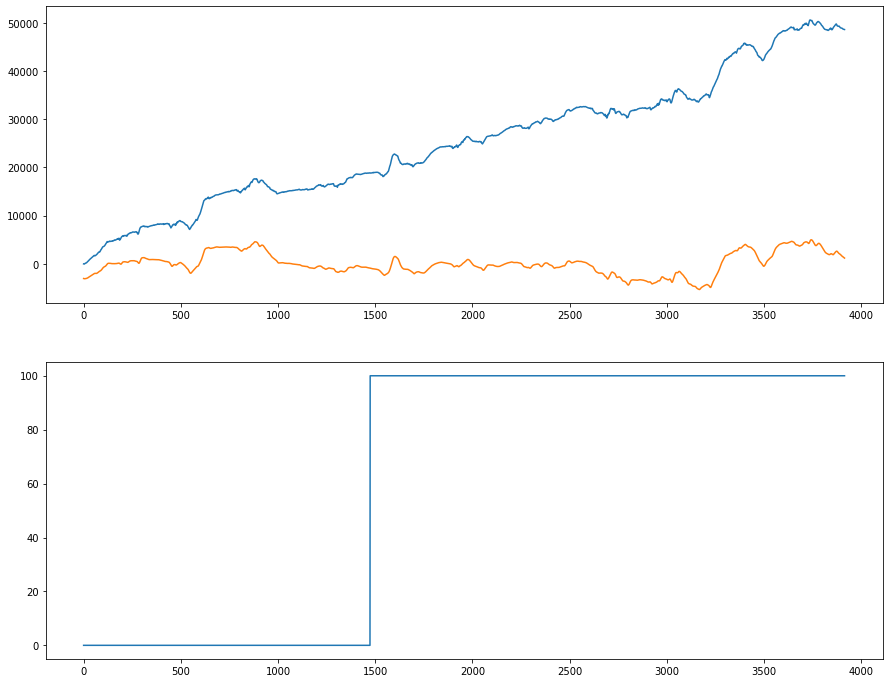

In [20]:
from geoist.snoopy.anomaly_detector import AnomalyDetector 
ts = dict(zip(range(len(data)),data['despiked'].values)) 
window_size = 10 
center = False 
data['ma'] = data['detrend'].rolling(window=window_size,center=center,min_periods=1).mean() 
tsb = dict(zip(range(len(data)),data['ma'].values)) 
# anomaly baseline 
algorithm_params = {'percent_threshold_upper': 20, 
'offset': 20000, 
'scan_window': 24, 
'confidence': 0.01} 
my_detector = AnomalyDetector(ts, baseline_time_series = tsb, algorithm_name = 'sign_test', 
algorithm_params = algorithm_params) 
score = my_detector.get_all_scores() 
fig = plt.figure(figsize=(15,12)) 
ax = fig.add_subplot(211) 
ax.plot(data['despiked'].dropna().values) 
ax.plot(data['ma'].dropna().values) 
ax = fig.add_subplot(212) 
ax.plot(score.timestamps,score.values)
plt.savefig("20-16.pdf")